In [1]:
import pandas as pd
import numpy as np
import math
import glob
import datetime

### вытащить площади
### привести к миллиметрам
### досчитать мелочи

In [387]:
path = '/mnt/SSD/education/aspirantura/CAMELS_ru/files/hydrology/2020-09-22_15-39'
all_files = glob.glob(path + '/*_Q_Day.Cmd.txt')

test = pd.read_csv(all_files[14], skiprows = 36, delimiter = ';', skipinitialspace = True)
test.Value = test.Value.replace(-999, np.NaN)
test['YYYY-MM-DD'] = pd.to_datetime(test['YYYY-MM-DD'])
test = test.drop(columns = ['hh:mm'])
test.rename(columns = {'YYYY-MM-DD': 'Date', 'Value': 'Q'}, inplace = True)
test['Qbase'] = np.NaN

### q_mean

In [364]:
test.Q.to_numpy()[~np.isnan(test.Q.to_numpy())].mean()

0.3417528910529519

### slope_fdc

In [365]:
np.nanquantile(test.Q.to_numpy(), q = 0.33), np.nanquantile(test.Q.to_numpy(), q = 0.66), np.nanquantile(test.Q.to_numpy(), q = 0.99)

(0.0, 0.0, 10.0)

In [367]:
try:
    (math.log(np.nanquantile(test.Q.to_numpy(), q = 0.33)) - math.log(np.nanquantile(test.Q.to_numpy(), q = 0.66)))/(0.66 - 0.33)
except ValueError:
    print('33 перцентиль = {}, 66 перцентиль = {}'.format(np.nanquantile(test.Q.to_numpy(), q = 0.33), np.nanquantile(test.Q.to_numpy(), q = 0.66)))
finally:
    print(
        (math.log(np.nanquantile(test.Q.to_numpy(), q = 0.33)+0.0009) - math.log(np.nanquantile(test.Q.to_numpy(), q = 0.66)+0.001))/(0.66 - 0.33))

33 перцентиль = 0.0, 66 перцентиль = 0.0
-0.31927428987220235


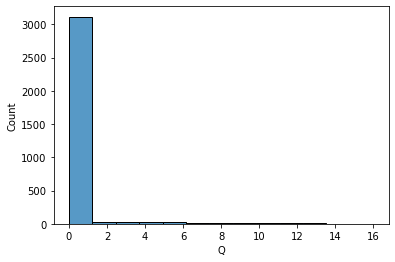

In [369]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(test.Q)

plt.show()

### baseflow_index

In [427]:
def clump_array(a):

    """
    Разбить период наблюдений на куски, в которых нет NaN
    """

    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

"Создаём отдельные вектора в соответствии с разбиением на куски без NaN"

###################################################################
def FirstPass(Q, alpha):

    q_f_1 = [[[] for _ in range(len(i))] for i in Q]
    q_b_1 = [[[] for _ in range(len(i))] for i in Q]

    for i in range(len(Q)):           
        """
        Задаём первые величины векторе "быстрого" стока

        """
        q_f_1[i][0] = Q[i][0]

        for j in range(len(Q[i])-1):
            """
            Для каждого куска считаем быстрый сток

            """
            q_f_1[i][j+1] = alpha * q_f_1[i][j] + 0.5 * (1 + alpha) * (Q[i][j+1] - Q[i][j])

        for j in range(len(Q[i])):
            if q_f_1[i][j] < 0:
                q_b_1[i][j] = Q[i][j]
            else:
                q_b_1[i][j] = Q[i][j] - q_f_1[i][j]

    Q_forward_1 = [q_f_1, q_b_1]

    return Q_forward_1

###################################################################

def BackwardPass(Q_forward_1, alpha):

    """
    Здесь Q - n-мерный лист в зависимости от числа разбиений
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_2 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):
        "последняя величина предыдущего шага - первая в обратном"
        q_f_2[i][-1] = Qb[i][-1]

        for j in range(len(Qq[i])-2, -1, -1):
            q_f_2[i][j] = alpha * q_f_2[i][j+1] + 0.5 * (1 + alpha) * (Qb[i][j] - Qb[i][j+1])

        for j in reversed(range(len(Qq[i]))):
            if q_f_2[i][j] < 0:
                q_b_2[i][j] = Qb[i][j]
            else:
                q_b_2[i][j] = Qb[i][j] - q_f_2[i][j]
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################

def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_3 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):

        "Теперь первая величина предыдущего шага - первая и здесь"

        q_f_3[i][0] = Qb[i][0]

        for j in range(len(Qb[i])-1):

            q_f_3[i][j+1] = alpha * q_f_3[i][j] + 0.5 * (1 + alpha) * (Qb[i][j+1] - Qb[i][j])

        for j in range(len(Qb[i])):
            if q_f_3[i][j] < 0:
                q_b_3[i][j] = Qb[i][j]
            else:
                q_b_3[i][j] = Qb[i][j] - q_f_3[i][j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################

def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    Qin = Q
    
    "отложим отраженные величины с конца и начала нашего ряда"
    Q_reflect = [[[] for _ in range(len(i) + 2 * reflect)] for i in Q]

    for i in range(len(Q_reflect)):

        Q_reflect[i][:reflect] = Q[i][(reflect):0:-1] #добавляем 

        Q_reflect[i][(reflect):(reflect + len(Q[i]))] = Q[i]

        Q_reflect[i][(reflect + len(Q[i])):(len(Q[i]) + 2 + 2 * reflect)] = Q[i][len(my_list)-2:len(my_list) - reflect - 2:-1]
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    
    Qbase = [i[reflect:(len(i)-reflect)] for i in Q1[1]]
    Qbase = [[0 if j < 0 else j for j in i] for i in Qbase]
    
    # расчёт взвешенного среднего для разбитого на куски ряда расходов
    
    len_Qbase = len([item for sublist in Qbase for item in sublist]) # длина всех расходов, без учёта пропусков
    weights_for_average = [len(i)/len_Qbase for i in Qbase] # вес для среднего по каждому элементу
    weighted_bfi = sum([weights_for_average[i] * np.mean(Qbase[i]/np.mean(Qin[i])) for i in range(len(Qbase))]) #взвешенное среднее по выпуклой комбинации

    return weighted_bfi, Qbase

### проверка на базовом датасете Anthony Ladson

In [428]:
import requests
import csv
url = "https://raw.github.com/TonyLadson/data/master/data/BassRiver@Loch.csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)

my_list = [int(i[0]) for i in my_list]

In [432]:

Q = clump_array(test.Q.to_numpy())

passes = 3
reflect = 30
alpha = 0.98

bfi, Qbase = BFI_calc(Q, 0.98, 3, 30)

In [436]:
bfi

0.01512110412867201

In [437]:
"""
Восстановления ряда baseflow с учётом ранее "выбитых" пропусков
"""
from itertools import groupby
Qbase_full = [list(group) for key, group in groupby(test.Q.to_numpy(), key=np.isnan)] # разбитие на группы по признаку. Получается n листов. NaN и !NaN разбиты по листам
mask_to_refill = [~np.isnan(i).any() for i in Qbase_full] # индексируем их как одинокие булевые величины

position_index = -1
for j, mask in enumerate(mask_to_refill):
    """
    Так как первичный разрезанный лист из функции clumped_array имеет в себе количество листов, такое же как и True, то восстанавливаем в соответствии
    
    Аргумент position_index подбирается в соответствии с присутсвием с True и адресуется к нужному куску в Qbase
    
    Всё перезаписывается в лист, где в перезаписываемых значениях эквивалентные по длине значения стока
    """
    if mask:
        position_index += 1
        Qbase_full[j] = Qbase[position_index]
    else:
        position_index = position_index
        Qbase_full[j] = Qbase_full[j]
            
Qbase_full = [item for sublist in Qbase_full for item in sublist] # лист листов в лист с учётом NaN

test.Qbase = Qbase_full # Добавляем его в исходный датафрейм

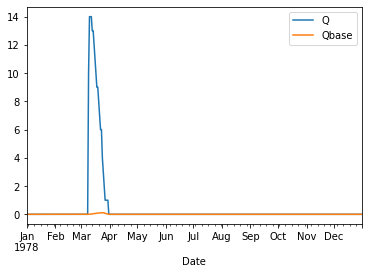

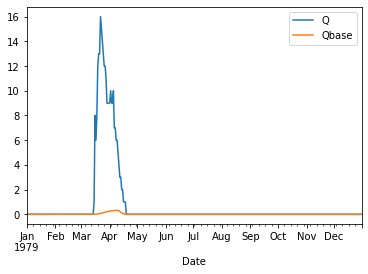

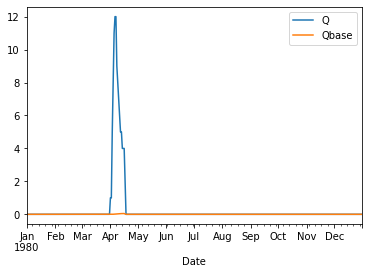

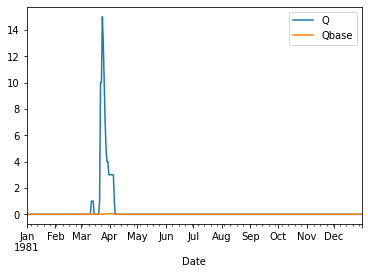

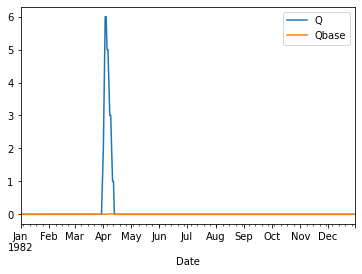

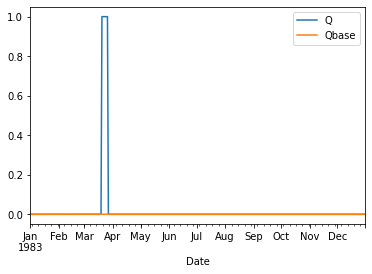

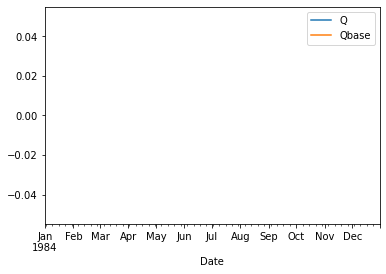

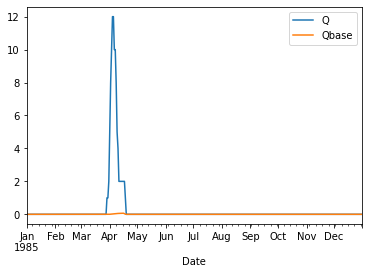

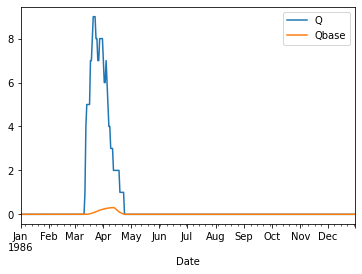

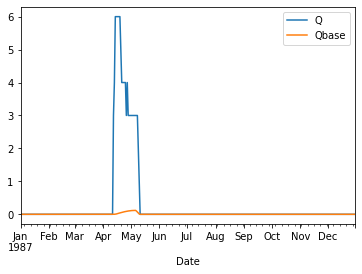

In [438]:
split_by_year = [test[test['Date'].dt.year == y].reset_index(drop = True) for y in test['Date'].dt.year.unique()]
for i in split_by_year:
    i = i.set_index('Date')
    ax = i.plot()


### hfd_mean

In [12]:
split_by_year = [test[test['Date'].dt.year == y].reset_index(drop = True) for y in test['Date'].dt.year.unique()]

hfd = list()

In [13]:
for i in range(len(split_by_year)):
    half_discharge = 0
    for j, discharge in enumerate(split_by_year[i].Value):    
        half_discharge += discharge
        if half_discharge > split_by_year[i].Value.sum()/2:
            break
    hfd.append(split_by_year[i].Date[j])
    

In [14]:
hfd

[Timestamp('1978-03-15 00:00:00'),
 Timestamp('1979-03-27 00:00:00'),
 Timestamp('1980-04-08 00:00:00'),
 Timestamp('1981-03-25 00:00:00'),
 Timestamp('1982-04-05 00:00:00'),
 Timestamp('1983-03-23 00:00:00'),
 Timestamp('1984-12-31 00:00:00'),
 Timestamp('1985-04-06 00:00:00'),
 Timestamp('1986-03-28 00:00:00'),
 Timestamp('1987-04-22 00:00:00')]

In [16]:
split_by_year

,Date,Value
0,1978-01-01,0.0
1,1978-01-02,0.0
2,1978-01-03,0.0
3,1978-01-04,0.0
4,1978-01-05,0.0
...,...,...
360,1978-12-27,0.0
361,1978-12-28,0.0
362,1978-12-29,0.0
363,1978-12-30,0.0
